<a href="https://colab.research.google.com/github/marionboynton/Rock-Classifier/blob/main/MaterialComposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Program to classify rock types from images sample from video of mining processing unit. If a large proportion of 'fines' (class of rock) are detected, an alert is signalled as this is considered to be contaminating the unit. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#install yagmail for email notifications 
#!pip install yagmail

In [ ]:
#import the necessary libaries
import os
from pathlib import Path
import sys
import pdb
import logging
import traceback
from PIL import Image as PImage
import pandas as pd
from functools import partial
import fastai
from fastai.basic_train import LearnerCallback, Learner, DataBunch, SmoothenValue, to_data, functools, \
    add_metrics, Module, nn
from fastai.imports import torch, F
import numpy as np
from torch.utils.data import Dataset
from numbers import Integral
import gc
import torchvision
from fastai.vision import *
import pandas as pd

In [ ]:
#from googlecolab.patches import cv2_imshow
from IPython.display import clear_output, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
#email notifications 
import yagmail

user = 'rockwarnings@gmail.com'
app_password = 'ftzrsbnygdbjhmyu'
to = 'rockwarnings@gmail.com'

subject = 'Fines Notification'


In [ ]:
#loading in the model
#Creating the labelled image databunch with batch size 16 and image size 128, 128
batch_size = 16
train_image_size = (128, 128)
image_dir = Path("/content/drive/Shared drives/DSI Module 2 Team Drive /DATA FINAL")
tfms = get_transforms()
labeled_data = ImageDataBunch.from_folder(image_dir, train = '.', ds_tfms=tfms,size=train_image_size,valid_pct = 0.2, bs = batch_size).normalize(imagenet_stats)

In [ ]:
#load model
learn = cnn_learner(labeled_data, models.resnet34, metrics=accuracy)
learn.load('/content/drive/Shared drives/module 2 rock videos/res18')

Learner(data=ImageDataBunch;

Train: LabelList (1891 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
chip,chip,chip,chip,chip
Path: /content/drive/Shared drives/DSI Module 2 Team Drive /DATA FINAL;

Valid: LabelList (472 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
lump,chip,chip,fines,pellets
Path: /content/drive/Shared drives/DSI Module 2 Team Drive /DATA FINAL;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
from fastai.vision import *

In [ ]:
#function to sample from frame

def sample_fastai(img_orig, x, y, win_size, cnn_size):
  #h, w, = img.shape
  img = Image(pil2tensor(img_orig, dtype=np.float32).div_(255))
  
  h, w, = img.shape[1], img.shape[2]

  delta = int(win_size/2)

  x0 = x - delta 
  x1 = x + delta
  y0 = y - delta
  y1 = y + delta

  if y0 < 0:
      y0 = int(0)
      y1 = int(win_size * 2)
  
  if y1 > h:
      y0 = int(h - win_size * 2)
      y1 = int(h)
  
  if x0 < 0:
      x0 = int(0)
      x1 = int(win_size * 2)
  
  if x1 > w:
      x0 = int(w - win_size * 2)
      x1 = int(w)

  img_sample = img.crop((x0,y0,x1,y1))
  img_cnn = img_sample.resize(cnn_size)

  return img_cnn, [x0,x1,y0,y1]

In [ ]:
#import video and capture frames
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_1.mp4"
cap = cv2.VideoCapture(vid_path)
N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_window_size = 15 # in pixels
cnn_img_size = 200 #

#dataframe to save the predictions of each frame
frame_preds = pd.DataFrame(index = [0, 1, 2, 3, 4])
frames_num = [0]


tic = time.process_time()
for frame in range(N_frames):
  has_img, img = cap.read()
  
  if has_img:

    crop_img = img[30:430, 145:420]
    #img_mono = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    
    # take n number of samples from reqions around the frame
    n = 5
    x_offset = np.linspace(0, 150, n)
    x_offset = np.random.permutation(x_offset)
    y_offset = np.linspace(0, 100, n)
    y_offset = np.random.permutation(y_offset)

    #create list to save predictions of sample
    sample_preds = []

    #loop through each sample
    for i in range(n):
      # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
      x = 200 + x_offset[i]
      y = 140 + y_offset[i]

      #single sample
      sample, rect = sample_fastai(img, int(x), int(y), sample_window_size, cnn_img_size)
      #show_image(sample)

      #predict on sample
      pred_class, pred_idx, outputs =  learn.predict(sample)

      #save the predictions
      sample_preds.append(pred_class.obj)


    # NOFITICATION FRAMES
    #first get the majority class of each sample
    samp_series = pd.Series(sample_preds)
    frame_preds[str(frame)] = samp_series  #store the classes in the dataframe
    frame_class = samp_series.mode()       #class that appears the most in the series

    if ['fines'] == list(frame_class):     #if fines majority class
      imgf = PImage.fromarray(img, 'RGB')
      imgf.save('/content/drive/Shared drives/module 2 rock videos/notifications/frame_' + str(frame) + '.png')
      last_fr = frames_num[-1] 
      frames_num.append(frame)         

      #email notfication 
      if (frame- last_fr)>7:
        content = []
        with yagmail.SMTP(user, app_password) as yag:
          content = ['Fines in bin!', '/content/drive/Shared drives/module 2 rock videos/notifications/frame_' + str(frame) + '.png']
          yag.send(to, subject, content)
    # COLAB
    # - - - - - - - - - - - - 
    #clear_output(wait=True)
    #cv2_imshow(sample) 
    #cv2.waitKey(1000) & 0xff
    # - - - - - - - - - - - - 

    # Local
    # - - - - - - - - - - - - 
    #cv2.imshow(img_mono)
    #cv2.waitKey(1000)
    # - - - - - - - - - - - -  

dt = time.process_time() - tic
print(N_frames)

print(dt/N_frames) # Samples per frame should be below 150 ms

1470
0.19576855910340132


In [ ]:
imgf.

'<PIL.Image.Image image mode=RGB size=640x480 at 0x7FF17CB74DD8>'

In [ ]:
#frames_num
#remove first element
#frames_num.pop(0)

#frames where alerts should be made
note_frames = [x for i,x in enumerate(frames_num) if (x- frames_num[i-1])>7]
note_frames

[]

In [ ]:
#Data for Plotting 

data = {
    'chip' : [], 'fines': [], 'lump': [], 'mixed': [], 'pellets':[]
}
for col, values in frame_preds.iteritems():
    frame_dict = Counter(values)
    for cls, counts in data.items():
      if cls in frame_dict:
        data[cls].append(frame_dict[cls])
      else:
        data[cls].append(0)
        
df = pd.DataFrame(data)
df = df.div(df.sum(axis=1), axis=0)


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<Figure size 432x288 with 0 Axes>

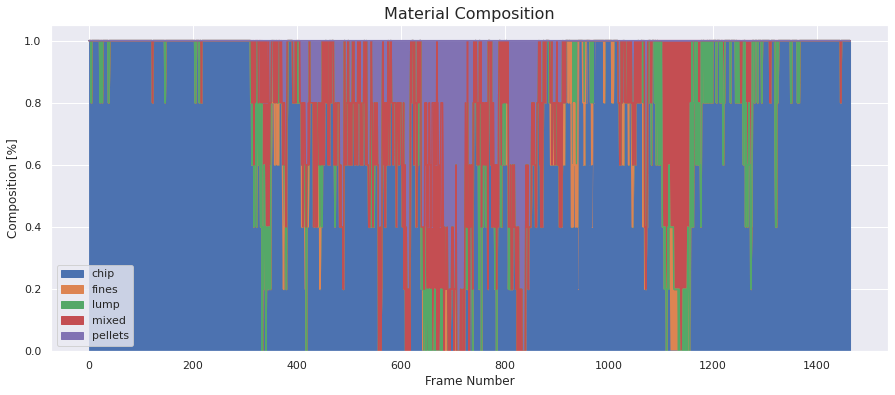

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.artist import Artist
sns.set()

fig = plt.figure()
df.plot(kind='area', figsize=(15,6) , stacked=True, xlabel='Frame Number', ylabel='Composition [%]', sort_columns=True, zorder=1)
plt.title('Material Composition', fontsize = 16, loc = 'center')
plt.vlines(note_frames, 0, 0.85, colors = 'k', linestyles='solid',label='warning' , linewidth = 2.5, zorder=2)
plt.plot(note_frames, [0.85]*len(note_frames) , 'kv',label='warning', zorder=3)
plt.show()